In [1]:
import keras
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 6

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from scipy import stats

Using TensorFlow backend.


# Experiment Parameters

In [2]:
widths = [4, 2, 2]
num_trials = 50

# Data Generation

# Construct & Train Network

In [3]:
def construct_network(X, y, widths):
    network = keras.Sequential()
    network.add(keras.layers.Dense(widths[0], input_shape = np.shape(X)[1:], activation = 'relu'))
    for i in range(1, len(widths)):
        network.add(keras.layers.Dense(widths[i], activation = 'relu'))
    network.add(keras.layers.Dense(1, activation = 'sigmoid'))
    network.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(1e-2))
    network.fit(
      X, 
      y, 
      epochs = 30, 
      verbose = False,
      batch_size = int(1.7 ** (np.log(len(X)) / np.log(5) + 1.5))
    )

    return network

    

## Keurnal Networks

In [4]:
def train_AKN(X, y):
    X_transform, X, y_transform, y = train_test_split(X, y, test_size = 0.1)
    #X_transform, y_transform = X, y
    network = construct_network(X_transform, y_transform, widths)

    polytope_memberships = []
    last_activations = X
    
    for layer_id in range(len(network.layers)):
        weights, bias = network.layers[layer_id].get_weights()
        preactivation = np.matmul(last_activations, weights) + bias
        if layer_id == len(widths) - 1:
            binary_preactivation = (preactivation > 0.5).astype('int')
        else:
            binary_preactivation = (preactivation > 0).astype('int')
        polytope_memberships.append(binary_preactivation)
        last_activations = preactivation * binary_preactivation

    polytope_memberships = np.concatenate(polytope_memberships, axis = 1)
    _, polytope_ids = np.unique(np.matmul(polytope_memberships, 2 ** np.arange(0, np.shape(polytope_memberships)[1])), return_inverse = True)


    #an array of all of the X-values of the class-wise means in each leaf
    polytope_means_X = []

    #an array of all of the y-values (i.e. class values) of the class-wise means in each leaf
    polytope_means_y = []

    #an array of all of the number of points that comprise the means in each leaf
    polytope_means_weight = []

    #an array of all of the average variances of the points in each leaf corresponding to 
    #a single class from the class-wise mean in that leaf
    polytope_means_var = []

    polytope_KDEs = []

    for polytope_value in np.unique(polytope_ids):
        for y_val in np.unique(y):
            idxs_in_polytope_of_class = np.where((y == y_val) & (polytope_ids == polytope_value))[0]
            if len(idxs_in_polytope_of_class) > 1:
                mean_X_in_polytope_of_class = np.mean(X[idxs_in_polytope_of_class], axis = 0)
                polytope_means_X.append(mean_X_in_polytope_of_class)
                #we already know the y value, so just append it 
                polytope_means_y.append(y_val)
                #compute the number of points in that leaf corresponding to that y value
                #and append to the aggregate array
                polytope_means_weight.append(len(idxs_in_polytope_of_class))
                #compute the distances of all the points in that leaf corresponding to that y value
                #from the mean X-value of the points in that leaf corresponding to that y value
                dists_in_polytope = np.sqrt(np.sum((X[idxs_in_polytope_of_class] - mean_X_in_polytope_of_class)**2, axis = 1))
                #compute the variance as the average distance of the class-wise points in that leaf 
                #and append to the aggregate array
                polytope_means_var.append(np.mean(dists_in_polytope))



    #convert to numpy array so we can easily refer to multiple sets of points as ra[idxs]
    polytope_means_y, polytope_means_X, polytope_means_weight, polytope_means_var = np.array(polytope_means_y), np.array(polytope_means_X), np.array(polytope_means_weight), np.array(polytope_means_var)

    #an array of all of the KDEs. Each KDE will be respondsible for computing the probability 
    #that a given set of inference points belongs to that class. Thus, we have separate KDEs 
    #for each class. The KDE at index i is the KDE that is responsible for computations on 
    #y_value = i
    KDEs = []
    #loop over the y values in the leaf means 
    for y_val in np.unique(polytope_means_y):
        #gather all of the leaf means corresponding to the given y value
        polytope_means_X_of_y_val = polytope_means_X[np.where(polytope_means_y == y_val)[0]]
        #father all of the weights corresponding to the given y value
        polytope_means_weight_of_y_val = polytope_means_weight[np.where(polytope_means_y == y_val)[0]]
        #compute the bandwidth as the average variance across the class-wise leaf means, weighted
        #by the number of points
        polytope_means_var_of_y_val = polytope_means_var[np.where(polytope_means_y == y_val)[0]]
        bandwidth=np.average(polytope_means_var_of_y_val, weights = polytope_means_weight_of_y_val)
        #train an sklearn KDE with a gaussian kernel with the bandwidth calculated above
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
        #fit the KDE on the leaf means corresponding to the given y value, weighted by
        #the weights corresponding to the given y value
        kde.fit(X = polytope_means_X_of_y_val, sample_weight = polytope_means_weight_of_y_val)

        #append the KDE to the aggregate array
        KDEs.append(kde)
    return KDEs

In [5]:
def generate_gaussian_parity(n):
    means = np.array([[-1, -1], [1, 1], [-1, 1], [1, -1]])
    X = np.concatenate([np.random.multivariate_normal(mean, 0.1 * np.eye(len(mean)),
                                                 size=int(n / 4)) for mean in means])

    y = np.concatenate([np.ones(int(n / 4)) * int(idx < 2) for idx in range(len(means))])

    random_indices_order = list(range(len(X)))
    np.random.shuffle(random_indices_order)
    return X[random_indices_order], np.array(y[random_indices_order]).astype('int')

In [6]:
def get_ece(predicted_posterior, y):
    hists = []
    hists_hat = []
    amts = []
    num_bins = 40
    eces_across_y_vals = []
    for y_val in np.unique(y):
        for i in range(num_bins):
            prop = i*1./num_bins
            inds = np.where((predicted_posterior[:, y_val] >= prop) & (predicted_posterior[:, y_val] <= prop+1./num_bins))[0]
            amts.append(len(inds))
            if len(inds) > 0:
                hists.append(len(np.where(y[inds] == y_val)[0])*1./len(inds))
                hists_hat.append(np.mean(predicted_posterior[inds, y_val]))
            else:
                hists.append(prop)
                hists_hat.append(prop + 0.5/num_bins)
        eces_across_y_vals.append(np.dot(np.abs(np.array(hists) - np.array(hists_hat)), amts) / np.sum(amts))
        return np.mean(eces_across_y_vals)

In [7]:
def get_brier(predicted_posterior, y):
    brier_across_y_vals = []
    for y_val in np.unique(y):
        brier_across_y_vals.append(np.nanmean((predicted_posterior[:, y_val] - (y == y_val).astype('int'))**2))
    return np.mean(brier_across_y_vals)

In [8]:
def clipped_mean(ra, low = 25, high = 75):
    ra = np.array(ra)
    lower_val = np.nanpercentile(ra, low)
    higher_val = np.nanpercentile(ra, high)
    return np.mean(ra[np.where((ra >= lower_val) & (ra <= higher_val))[0]])

In [9]:
def hellinger_explicit(p, q):
    """Hellinger distance between two discrete distributions.
       Same as original version but without list comprehension
    """
    return np.sum((np.sqrt(p) - np.sqrt(q)) ** 2) / np.sqrt(2)

In [10]:
X, y = generate_gaussian_parity(n = int(1e6))
X_test, y_test = generate_gaussian_parity(n = 1000)

In [11]:
xx, yy = np.meshgrid(np.arange(-1, 1, (2) / 100),
                      np.arange(-1, 1, (2) / 100))

def pdf(x):
    mu01, mu02, mu11, mu12 = [[-1, -1], [1, 1], [-1, 1], [1, -1]]
    cov = 0.25 * np.eye(2)
    inv_cov = np.linalg.inv(cov) 

    p0 = (
        np.exp(-(x - mu01)@inv_cov@(x-mu01).T) 
        + np.exp(-(x - mu02)@inv_cov@(x-mu02).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    p1 = (
        np.exp(-(x - mu11)@inv_cov@(x-mu11).T) 
        + np.exp(-(x - mu12)@inv_cov@(x-mu12).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    return p1/(p0+p1)

true_posterior = np.array([pdf(x) for x in tqdm(np.c_[xx.ravel(), yy.ravel()])])

In [12]:
def get_network_y_proba(X, y, n, X_test):
    random_indices = np.random.choice(len(X), int(n))
    X, y = X[random_indices], y[random_indices]
    network = construct_network(X, y, widths)
    class_1_posteriors = network.predict_proba(X_test)
    
    class_1_posteriors_grid = network.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    return np.concatenate([1 - class_1_posteriors, class_1_posteriors], axis = 1), np.concatenate([1 - class_1_posteriors_grid, class_1_posteriors_grid], axis = 1)
    

def get_KDE_y_proba(X, y, n, X_test):
    random_indices = np.random.choice(len(X), int(n))
    X, y = X[random_indices], y[random_indices]
    KDEs = train_AKN(X, y)
    y_proba_unnormalized = np.zeros((len(X_test), len(KDEs)))
    #loops over the KDEs (and thus, implicitly, the y-values)
    for y_val in range(len(KDEs)):
        #compute the (unnormalized) posterior for the KDE corresponding
        #to y_val. NOTE: we perform np.exp since the score_samples 
        #function returns the log of the probability of belonging to that 
        #class, so we must invert the log through an exponential
        y_proba_unnormalized[:, y_val] = np.exp(KDEs[y_val].score_samples(X_test))

    y_proba = y_proba_unnormalized.copy()
    for y_val in range(np.shape(y_proba)[1]):
        y_proba[:, y_val] /= np.sum(y_proba_unnormalized, axis = 1)
        
    y_proba_unnormalized_grid = np.zeros((len(np.c_[xx.ravel(), yy.ravel()]), len(KDEs)))
    #loops over the KDEs (and thus, implicitly, the y-values)
    for y_val in range(len(KDEs)):
        #compute the (unnormalized) posterior for the KDE corresponding
        #to y_val. NOTE: we perform np.exp since the score_samples 
        #function returns the log of the probability of belonging to that 
        #class, so we must invert the log through an exponential
        y_proba_unnormalized_grid[:, y_val] = np.exp(KDEs[y_val].score_samples(np.c_[xx.ravel(), yy.ravel()]))

    y_proba_grid = y_proba_unnormalized_grid.copy()
    for y_val in range(np.shape(y_proba)[1]):
        y_proba_grid[:, y_val] /= np.sum(y_proba_unnormalized_grid, axis = 1)
    
    return y_proba, y_proba_grid

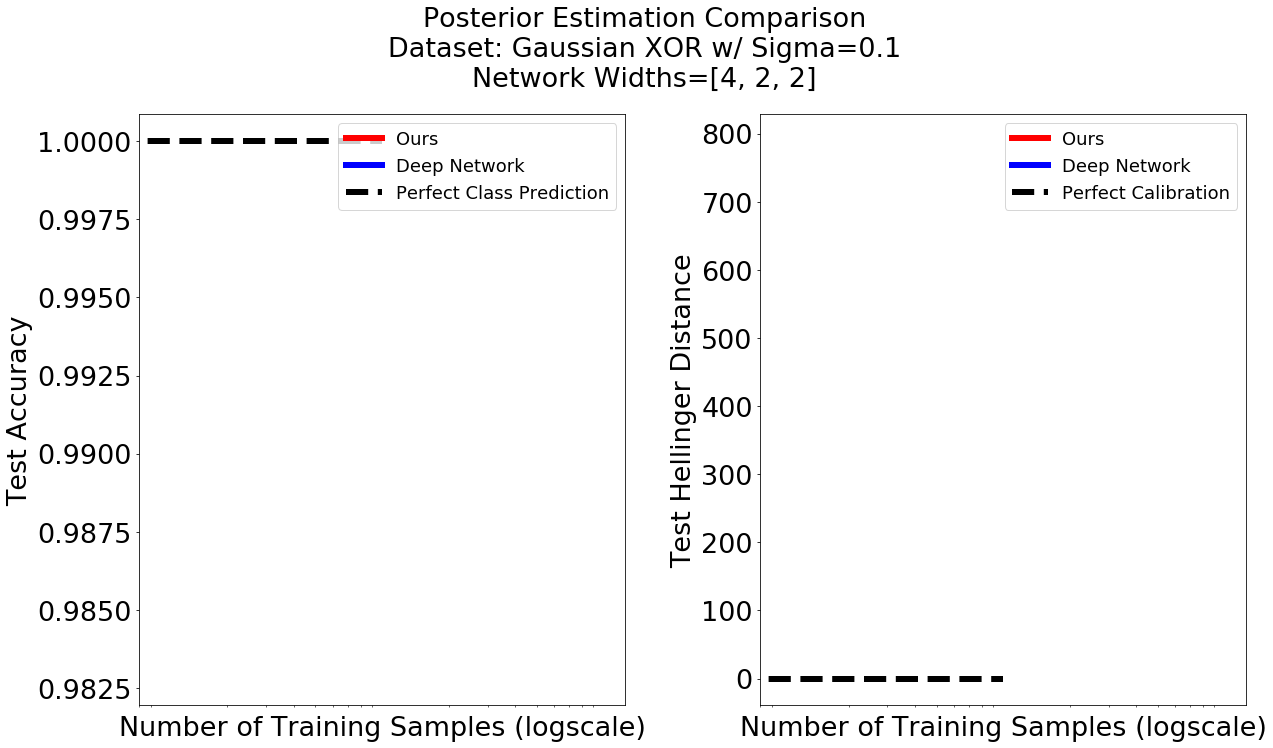

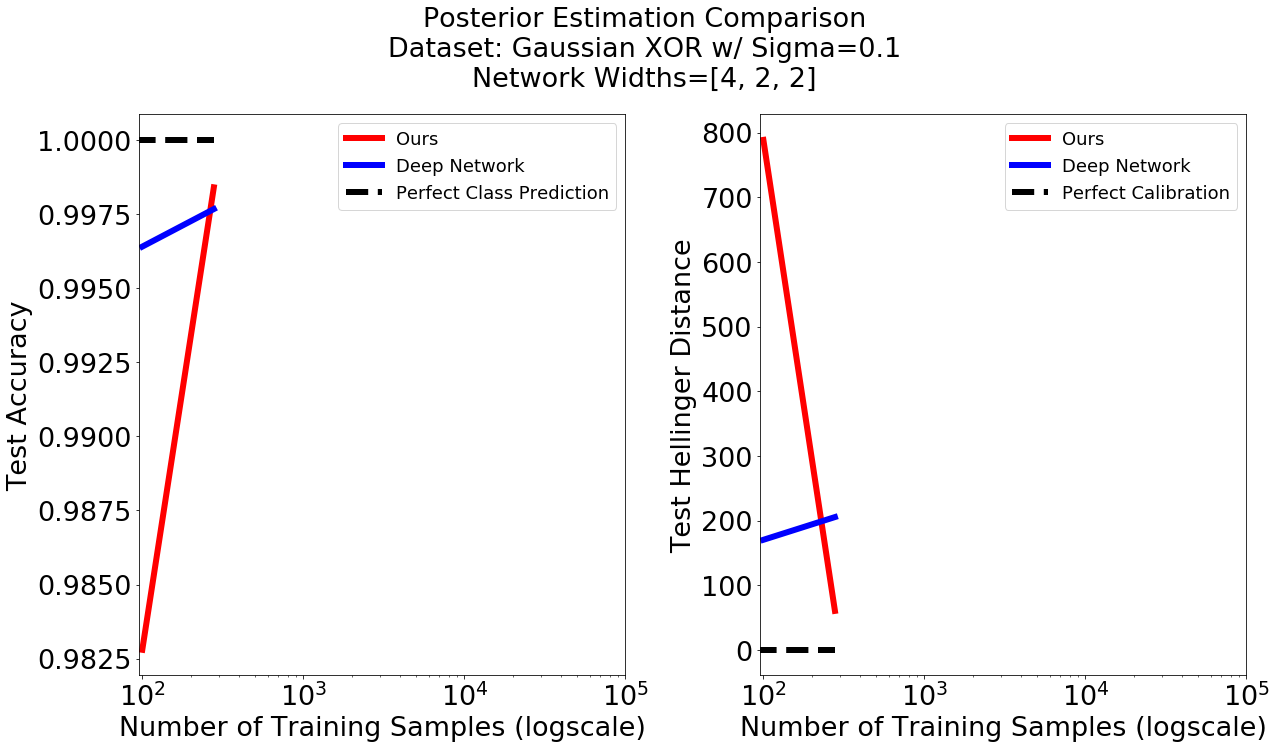

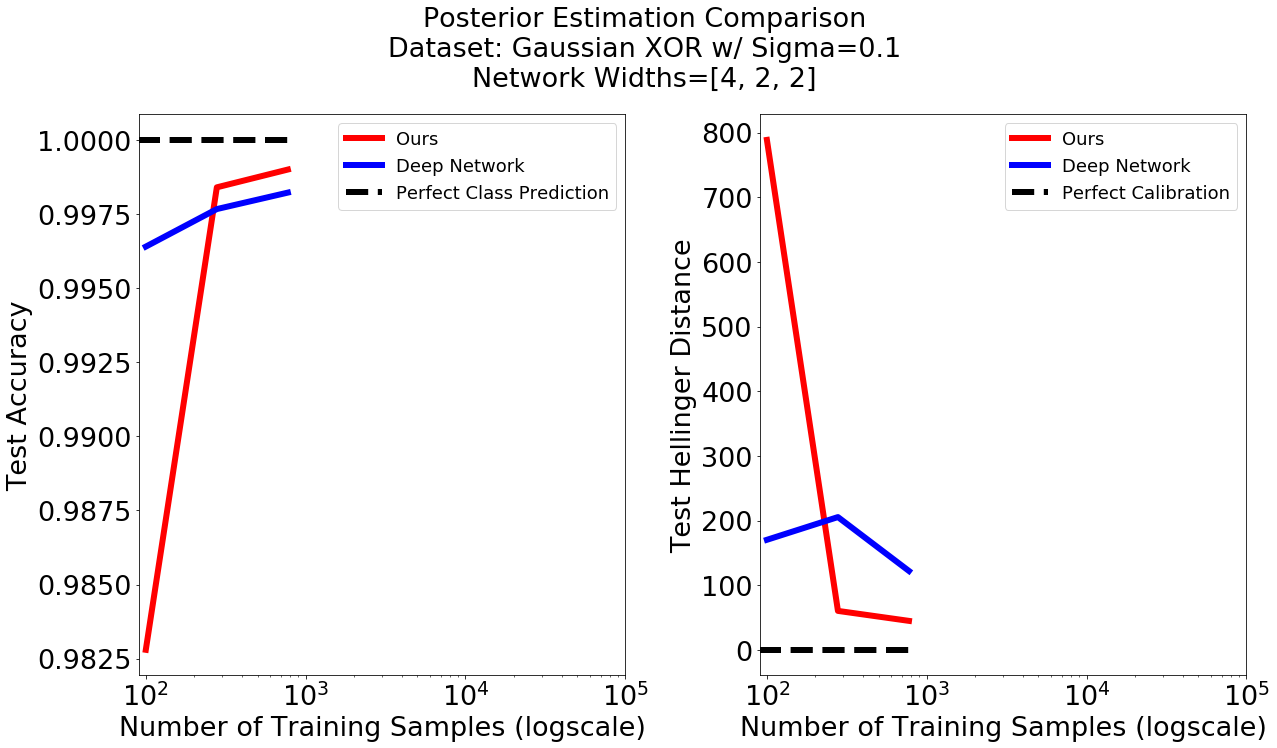

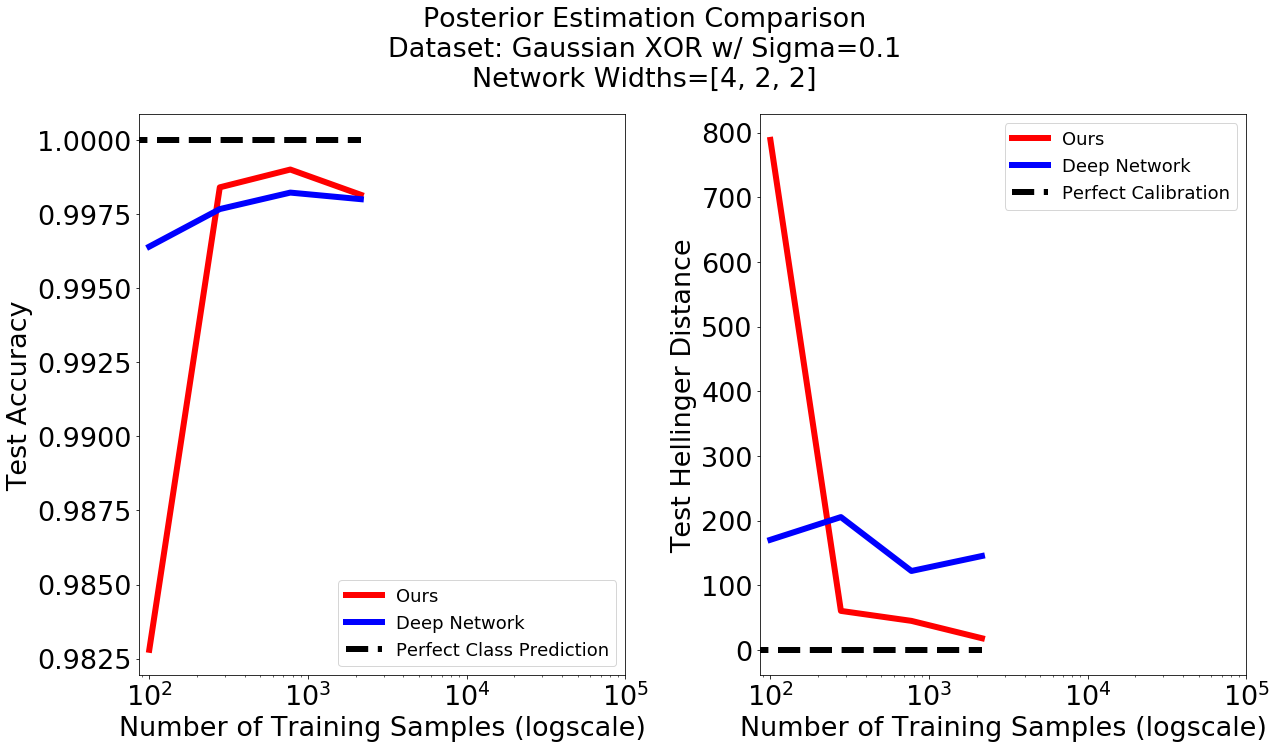

In [ ]:
KDE_acc_means = []
network_acc_means = []

KDE_acc_stds = []
network_acc_stds = []

KDE_brier_means = []
network_brier_means = []

KDE_brier_stds = []
network_brier_stds = []
n_ra = np.logspace(2, 6, num = 10, base = 10)
ticks = np.arange(np.min(n_ra), np.max(n_ra), step = int((np.max(n_ra) - np.min(n_ra)) // 4))
ticks_ra = np.array([int(str(tick)[:1]) * 10 ** int(np.log10(tick)) for tick in ticks])
for n in tqdm(n_ra):
    network_y_test_proba_across_trials = np.array([get_network_y_proba(X, y, n, X_test) for _ in tqdm(range(num_trials))])
    KDE_y_test_proba_across_trials = np.array([get_KDE_y_proba(X, y, n, X_test) for _ in tqdm(range(num_trials))])

    
    KDE_accs_across_trials = []
    network_accs_across_trials = []
    KDE_briers_across_trials = []
    network_briers_across_trials = []
    for trial_idx in range(num_trials):
        KDE_accs_across_trials.append(np.nanmean(np.argmax(KDE_y_test_proba_across_trials[trial_idx, 0], axis = 1) == y_test))
        network_accs_across_trials.append(np.nanmean(np.argmax(network_y_test_proba_across_trials[trial_idx, 0], axis = 1) == y_test))
        
        KDE_briers_across_trials.append(hellinger_explicit(KDE_y_test_proba_across_trials[trial_idx, 1][:, 0], true_posterior))
        network_briers_across_trials.append(hellinger_explicit(network_y_test_proba_across_trials[trial_idx, 1][:, 0], true_posterior))
        
    KDE_acc_means.append(clipped_mean(KDE_accs_across_trials, 90, 100))
    network_acc_means.append(clipped_mean(network_accs_across_trials, 90, 100))
    
    KDE_brier_means.append(clipped_mean(KDE_briers_across_trials, 0, 10))
    network_brier_means.append(clipped_mean(network_briers_across_trials, 0, 10))

    figs, ax = plt.subplots(1, 2, figsize = (18, 9))
    figs.set_facecolor("white")

    ax[0].tick_params(axis='both', which='major', labelsize=27)
    ax[0].plot(n_ra[:len(KDE_acc_means)] , KDE_acc_means, label = "Ours", c = "red")
    ax[0].plot(n_ra[:len(KDE_acc_means)], network_acc_means, label = "Deep Network", c = "blue")
    ax[0].hlines(1.0, 0, n_ra[len(KDE_acc_means) - 1], linestyle = "dashed", label = "Perfect Class Prediction", color = "black")
    ax[0].legend(fontsize = 18)
    ax[0].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
    ax[0].set_ylabel("Test Accuracy", fontsize = 27)
    ax[0].set_xscale("log")
    ax[0].set_xticks(10 ** np.arange(np.log10(np.min(ticks_ra[:len(KDE_acc_means)])), np.log10(np.max(ticks_ra[:len(KDE_acc_means)]))))

    ax[1].tick_params(axis='both', which='major', labelsize=27)
    ax[1].plot(n_ra[:len(KDE_acc_means)] , KDE_brier_means, label = "Ours", c = "red")
    ax[1].plot(n_ra[:len(KDE_acc_means)], network_brier_means, label = "Deep Network", c = "blue")
    ax[1].hlines(0.0, 0, n_ra[len(KDE_acc_means) - 1], linestyle = "dashed", label = "Perfect Calibration", color = "black")
    ax[1].legend(fontsize = 18)
    ax[1].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
    ax[1].set_ylabel("Test Hellinger Distance", fontsize = 27)
    ax[1].set_xscale("log")
    ax[1].set_xticks(10 ** np.arange(np.log10(np.min(ticks_ra[:len(KDE_acc_means)])), np.log10(np.max(ticks_ra[:len(KDE_acc_means)]))))

    figs.tight_layout()

    figs.suptitle("Posterior Estimation Comparison\nDataset: Gaussian XOR w/ Sigma=0.1\nNetwork Widths={}".format(widths), fontsize=27, y = 1.15)

    plt.show()

In [ ]:
figs, ax = plt.subplots(1, 2, figsize = (18, 9))
figs.set_facecolor("white")

ax[0].tick_params(axis='both', which='major', labelsize=27)
ax[0].plot(n_ra , KDE_acc_means, label = "Ours", c = "red")
ax[0].plot(n_ra, network_acc_means, label = "Deep Network", c = "blue")
ax[0].hlines(1.0, 0, n_ra[-1], linestyle = "dashed", label = "Perfect Class Prediction", color = "black")
ax[0].legend(fontsize = 18)
ax[0].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
ax[0].set_ylabel("Test Accuracy", fontsize = 27)
ax[0].set_xscale("log")

ax[1].tick_params(axis='both', which='major', labelsize=27)
ax[1].plot(n_ra , KDE_brier_means, label = "Ours", c = "red")
ax[1].plot(n_ra, network_brier_means, label = "Deep Network", c = "blue")
ax[1].hlines(0.0, 0, n_ra[-1], linestyle = "dashed", label = "Perfect Calibration", color = "black")
ax[1].legend(fontsize = 18)
ax[1].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
ax[1].set_ylabel("Test Hellinger Distance", fontsize = 27)
ax[1].set_xscale("log")


figs.tight_layout()

figs.suptitle("Posterior Estimation Comparison\nDataset: Gaussian XOR w/ Sigma=0.1\nNetwork Widths={}".format(widths), fontsize=27, y = 1.15)

plt.show()